In [1]:
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.model_selection import  GridSearchCV, StratifiedKFold
from sklearn.metrics import  f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from IPython.display import display
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

##### Code for plotting confusion matrix

In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

##### Load the data

In [3]:
train = pd.read_csv('../data/original/training_dataset.csv')
test = pd.read_csv('../data/original/evaluation_dataset.csv')

print(train['Bankrupt?'].value_counts())
print(test['Bankrupt?'].value_counts()) 

0    5279
1     176
Name: Bankrupt?, dtype: int64
0    1320
1      44
Name: Bankrupt?, dtype: int64


### Preprocessing

##### Remove some outliers <br>
Statistical approach: IQR Test, gives good results in our case

In [4]:
# Removes outliers. 1 bankrupt companie and 442 non banckrupt. 
def outliers_removal(feature, feature_name, dataset):
    q1 = np.percentile(feature, 25)
    q3 = np.percentile(feature, 75)
    iqr = q3 - q1
    fence = iqr * 1.5
    fence_lower = q1 - fence 
    fence_upper = q3 + fence
    outliers = [x for x in feature if x < fence_lower or x > fence_upper]
    dataset = dataset.drop(dataset[(dataset[feature_name] > fence_upper) | (dataset[feature_name] < fence_lower)].index)
    return dataset

# Only remove outliers from train data
for col in train:
    new_train = outliers_removal(train[col], str(col), train)

#Original
display(train['Bankrupt?'].value_counts())
# New
display(new_train['Bankrupt?'].value_counts())

0    5279
1     176
Name: Bankrupt?, dtype: int64

0    4837
1     175
Name: Bankrupt?, dtype: int64

##### Make a train/test splitt

In [5]:
y_train = new_train['Bankrupt?']
X_train = new_train.drop(['Bankrupt?'], axis = 1)

y_test = test['Bankrupt?']
X_test = test.drop(['Bankrupt?'], axis = 1)

print(y_train.value_counts())
print(y_test.value_counts()) 

0    4837
1     175
Name: Bankrupt?, dtype: int64
0    1320
1      44
Name: Bankrupt?, dtype: int64


##### Additional outlier removal

In [6]:
# Try and also remove outliers with this method

# iso = IsolationForest(contamination=0.3)
# yhat = iso.fit_predict(X_train)

# # select all rows that are not outliers
# mask = yhat != -1
# X_train = X_train.to_numpy()
# y_train = y_train.to_numpy()
# print(X_train.shape, y_train.shape)
# X_train, y_train = X_train[mask, :], y_train[mask]
# print(X_train.shape, y_train.shape)

In [7]:
# Or remove outliers with this method

# ee = OneClassSVM(nu=0.03)
# yhat = ee.fit_predict(X_train)

# # select all rows that are not outliers
# mask = yhat != -1
# X_train = X_train.to_numpy()
# y_train = y_train.to_numpy()
# print(X_train.shape, y_train.shape)
# X_train, y_train = X_train[mask, :], y_train[mask]
# print(X_train.shape, y_train.shape)

In [8]:
# Or remove outliers with this method

# lof = LocalOutlierFactor(n_neighbors=10, contamination=0.3)
# yhat = lof.fit_predict(X_train)

# mask = yhat != -1
# X_train = X_train.to_numpy()
# y_train = y_train.to_numpy()
# print(X_train.shape, y_train.shape)
# X_train, y_train = X_train[mask, :], y_train[mask]
# print(X_train.shape, y_train.shape)

### Pipeline

##### Example using Logistic Regression
Sampling using SMOTE. Scale. SelectKBest for feature selection. PCA to reduce dimentionality and <br> 
removing some outliers??? StratifiedKFold for crosscalidation. Try logistic regression and tune parameters with GridSearch by using params. 

In [9]:
# StratifiedKFold for crossvalidation in GridSearch
cros_val = StratifiedKFold(n_splits=5)

# Looks to better than minmaxscaler for some tre based estimators 
scaler =  StandardScaler() 

# Usualy use minmaxscaler. 
# minmax performs for example better for logistic regression in this case.
scaler2 = MinMaxScaler()

# Do feature selection with SelectKBest.
feature_selection = SelectKBest(f_classif)  

# Oversample data with SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=20)

# Dimentionality reduction with PCA.
pca = PCA() 

# Pick an estimator to train
estimator = LogisticRegression(random_state=20)

# Define a pipeline. Use imblearn library for pipeline to be able to include SMOTE
pipeline = imbpipeline(steps = [('scaler', scaler2), 
                                ('selection', feature_selection), 
                                ('pca', pca), 
                                ('smote', smote), 
                                ('reg', estimator)
                                ])

# Example parameters that should be tested in the GridSearch
params = {'selection__k':[40,50,60,70],
          'pca__n_components':[7,10,15],
          'reg__penalty': ['l2'],
          'reg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'reg__class_weight': ['balanced'],
          'reg__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
          }

# use best_params if you do not want to do a full GridSearch (for comparison in later iterations)
best_params = {'selection__k':[50],
          'pca__n_components':[10],
          'reg__penalty': ['l2'],
          'reg__C': [10],
          'reg__class_weight': ['balanced'],
          'reg__solver':['newton-cg']
          }

# Make a scorer that vaules puts less weight on precision, more weight on recall.
from sklearn.metrics import fbeta_score, make_scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

# GridSearch for hyperparameter-optimization 
best_model = GridSearchCV(pipeline, best_params, scoring=f2_scorer, cv=cros_val) 

# fit our model
best_model.fit(X_train, y_train)

# Prints the best parameters from the GridSearch
print(best_model.best_params_)

{'pca__n_components': 10, 'reg__C': 10, 'reg__class_weight': 'balanced', 'reg__penalty': 'l2', 'reg__solver': 'newton-cg', 'selection__k': 50}


              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1320
           1       0.16      0.82      0.27        44

    accuracy                           0.85      1364
   macro avg       0.58      0.84      0.59      1364
weighted avg       0.97      0.85      0.90      1364

f1-score: 0.2657
f2-score: 0.4467


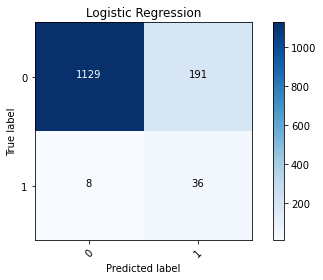

In [10]:
# Make a prediction
y_pred_test = best_model.predict(X_test) 

# Print a classification report for our prediction
print(classification_report(y_test, y_pred_test))
print(f'f1-score: {round(f1_score(y_test, y_pred_test), 4)}')
print(f'f2-score: {round(fbeta_score(y_test, y_pred_test, beta=2), 4)}')

# Look at testing results in confusion matrix
test_conf_matrix = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(test_conf_matrix, classes=[0, 1], title='Logistic Regression')